## 18 - Détections d'oiseaux à proximité d'un parc éolien en mer

Ce notebook a pour but de fusionner les parties de clustering (détermination des conditions météo) et d'optical flow (tracking des oiseaux)

On importe les bibliothèques et les fichiers python nécessaires

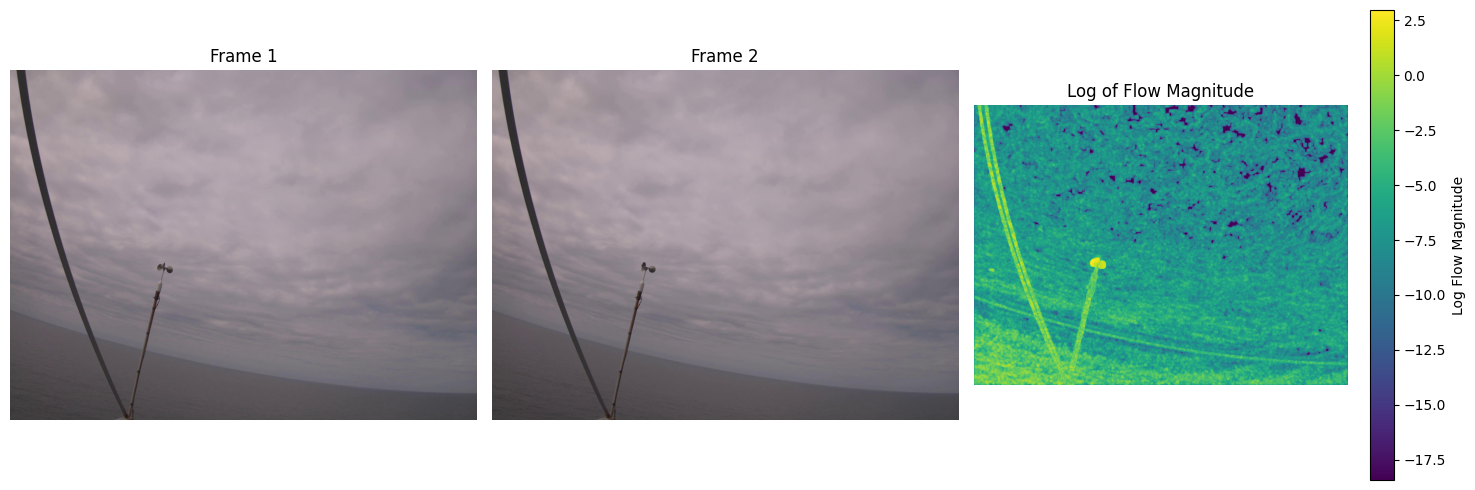

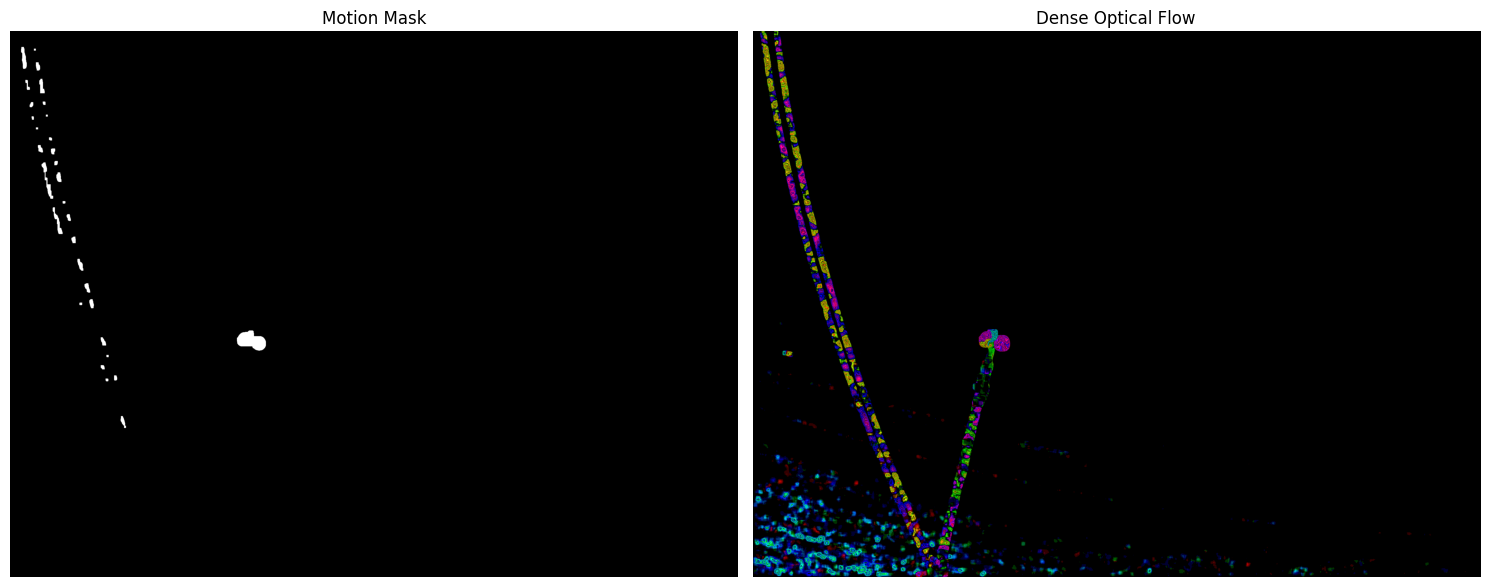

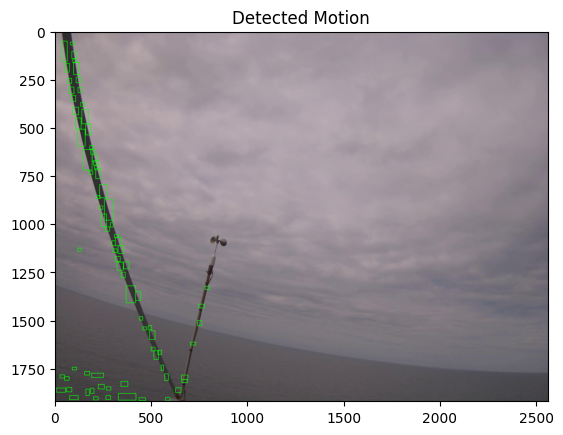

GIF saved at output_gifs\detections9.gif
GIF saved at detections9.gif
GIF saved at output_gifs\detections13.gif
GIF saved at detections13.gif
GIF saved at output_gifs\detections14.gif
GIF saved at detections14.gif
GIF saved at output_gifs\detections7.gif
GIF saved at detections7.gif
Aggregated Evaluation Metrics:
Precision: 0.02
True Positives: 6
False Positives: 280
False Negatives: 0
Signal-to-Noise Ratio (SNR): 0.02
GIF saved at output_gifs\detections11.gif
GIF saved at detections11.gif
Aggregated Evaluation Metrics:
Precision: 0.01
True Positives: 8
False Positives: 554
False Negatives: 4
Signal-to-Noise Ratio (SNR): 0.01
Traitement de sequence=1...
GIF saved at output_gifs\detections_sequence_1.gif
GIF saved at detections_sequence_1.gif
Traitement de sequence=3...
GIF saved at output_gifs\detections_sequence_3.gif
GIF saved at detections_sequence_3.gif
Traitement de sequence=5...
GIF saved at output_gifs\detections_sequence_5.gif
GIF saved at detections_sequence_5.gif
Traitement d

In [6]:
import sys
import os
import import_ipynb

# Importer le notebook
import ClusteringComplet as cc
import Optical_Flow_v2 as of

##### Extraction d'une seule image pour chacune des 30 premières séquences

In [7]:
import os
import imageio
import numpy as np

def extract_one_image_per_sequence(folder_path, num_sequences, N):
    frames = []
    max_seq = min(N*num_sequences, 156)

    for sequence_id in range(1, max_seq + 1, N):
        # Extraire une seule image pour chaque séquence
        for file_name in os.listdir(folder_path):
            if file_name.startswith(f"sequence={sequence_id}_") and file_name.endswith(".jpg"):
                frames.append(file_name)
                break
                
    return frames

##### Classification de la météo de la vidéo

In [8]:
from tkinter import Image
import re

def trouver_cluster_image(image_path, model, kmeans_ciel, kmeans_mer):
        # Charger l'image
        img = Image.open(image_path)
        
        pattern = re.compile(r"-(\d+)_frame")
        
        match = pattern.search(image_path)
        if match:
            numero_frame = int(match.group(1))
            # Numéro pair = ciel ;; Numéro impair = mer
        else:
            print(f"Nom de fichier non conforme : {image_path}")
        
        # Découper l'image en fonction de son type (ciel ou mer)
        if numero_frame % 2 == 0:
            img_decoupee = cc.decoupe_rectangle_ciel(img)
            kmeans = kmeans_ciel
            str = "ciel"
            
        else:
            img_decoupee = cc.decoupe_rectangle_mer(img)
            kmeans = kmeans_mer
            str = "mer"
        
        # Extraire les features de l'image découpée
        features = cc.extract_features(img_decoupee, model)
        
        # Réduire les dimensions des features avec PCA
        features_reduites = cc.pca.transform(np.array([features]))
        
        # Trouver le cluster idéal avec KMeans
        cluster = kmeans.predict(features_reduites)
        
        return (cluster[0], str)
    
from PIL import Image

# Dossier contenant les frames
folder_path = "../DATASET_SENSEA/images"
# Traiter les séquences 1 à 30
image_paths = extract_one_image_per_sequence(folder_path, 65, N=2)

print(f"Nombre d'images: {len(image_paths)}")
print(image_paths)
cluster_de_chaque_sequence = []

for i in range(len(image_paths)):
    image_path = image_paths[i]
    cluster_et_type = trouver_cluster_image(f"{folder_path}/{image_path}", cc.model, cc.kmeans_ciel, cc.kmeans_mer)
    cluster_de_chaque_sequence.append(cluster_et_type)

Nombre d'images: 65
['sequence=1_video-20220511_132051-00_frame=3720.jpg', 'sequence=3_video-20220511_132051-07_frame=5400.jpg', 'sequence=5_video-20220511_132051-07_frame=5245.jpg', 'sequence=7_video-20220511_132051-10_frame=5254.jpg', 'sequence=9_video-20220511_132051-11_frame=4742.jpg', 'sequence=11_video-20220511_133053-00_frame=7848.jpg', 'sequence=13_video-20220511_133053-02_frame=6846.jpg', 'sequence=15_video-20220511_133053-06_frame=3937.jpg', 'sequence=17_video-20220511_133053-08_frame=1618.jpg', 'sequence=19_video-20220511_133053-08_frame=6192.jpg', 'sequence=21_video-20220511_133053-09_frame=6492.jpg', 'sequence=23_video-20220511_133053-10_frame=6441.jpg', 'sequence=25_video-20220511_133053-11_frame=3587.jpg', 'sequence=27_video-20220511_134055-00_frame=3662.jpg', 'sequence=29_video-20220511_134055-00_frame=8195.jpg', 'sequence=31_video-20220511_134055-01_frame=2029.jpg', 'sequence=33_video-20220511_134055-01_frame=4349.jpg', 'sequence=35_video-20220511_180154-07_frame=2700.

##### On calcule le tableau des couples (cluster, sequence)

##### Maintenant, on calcule la précision du tracking en fonction du cluster

In [9]:
somme_precisions_cluster = {"ciel" :[0,0,0,0,0], "mer" : [0,0,0,0,0]}
nb_sequence_cluster = {"ciel" :[0,0,0,0,0], "mer" : [0,0,0,0,0]}
tous_resultats = of.all_results

for i in range(len(image_paths)):
    cluster, ciel_mer = cluster_de_chaque_sequence[i]
    resultats = tous_resultats[i]
    somme_precisions_cluster[ciel_mer][cluster] += resultats["precision"]
    nb_sequence_cluster[ciel_mer][cluster] += 1

print(somme_precisions_cluster)
print(nb_sequence_cluster)

for i in range(5):
    for str in ["ciel", "mer"] :
        if nb_sequence_cluster[str][i] == 0 :
            print(f"Pas de tracking sur le cluster {i} des images de {str}")
        else :
            print(f"La précision de la détection sur le cluster {i} des images de {str} est : {somme_precisions_cluster[str][i] / nb_sequence_cluster[str][i]}")
    

{'ciel': [0, 0.8418509230368135, 0, 0, 0], 'mer': [0.025600907026140013, 0.0435420588211027, 0.0, 0.0, 0.00026096033402922753]}
{'ciel': [0, 34, 0, 0, 0], 'mer': [7, 21, 1, 1, 1]}
Pas de tracking sur le cluster 0 dy type d'image ciel
La précision de la détection sur le cluster 0 du type d'image mer est : 0.003657272432305716
La précision de la détection sur le cluster 1 du type d'image ciel est : 0.024760321265788632
La précision de la détection sur le cluster 1 du type d'image mer est : 0.002073431372433462
Pas de tracking sur le cluster 2 dy type d'image ciel
La précision de la détection sur le cluster 2 du type d'image mer est : 0.0
Pas de tracking sur le cluster 3 dy type d'image ciel
La précision de la détection sur le cluster 3 du type d'image mer est : 0.0
Pas de tracking sur le cluster 4 dy type d'image ciel
La précision de la détection sur le cluster 4 du type d'image mer est : 0.00026096033402922753
